In [48]:
import preprocessing.preprocessing as pp
import torch
from models import baselines
import numpy as np
import evaluation.evaluation as ev
import training.training as tt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
from torch_geometric.utils.convert import from_networkx

# Load the graphs

In [49]:
G_load = nx.read_gpickle("saved_data/graph_gt_pickle_nolab_upsamp")
L_load = nx.read_gpickle("saved_data/graph_gt_L_pickle_upsamp")
#L_load = pp.make_dual(G_load)

#L05_train = nx.read_gpickle("saved_data/graph_L05_train_gt_pickle_upsamp")
#L05_test = nx.read_gpickle("saved_data/graph_L05_test_gt_pickle_upsamp")

#L05_train_torch = from_networkx(L05_train)
#L05_test_torch = from_networkx(L05_test)


In [50]:
L_load_torch = from_networkx(L_load)

splitter = tt.Splitter(L_load_torch)
L08_train_nodes, L02_test_nodes, splitval = splitter.split_geometric((0,1,0), 0.8)


train_list = np.array(list(L_load.nodes()))[L08_train_nodes].tolist()
train_nodes = [(elem[0],elem[1]) for elem in train_list]

test_list = np.array(list(L_load.nodes()))[L02_test_nodes].tolist()
test_nodes = [(elem[0],elem[1]) for elem in test_list]

L08_train = L_load.subgraph(train_nodes)
L02_test = L_load.subgraph(test_nodes)

#L08_train_nodes = np.array(list(L_load.nodes()))[L08_train_nodes]
#L02_test_nodes = np.array(list(L_load.nodes()))[L02_test_nodes]
#
#L08_train = nx.induced_subgraph(L_load, L08_train_nodes)
#L02_test = nx.induced_subgraph(L_load, L02_test_nodes)

In [51]:
split_wholeG = nx.union(L08_train, L02_test)
# make the graph a torch obj
split_wholeG_torch = from_networkx(split_wholeG)
#split_wholeG_y, _, _ =  pp.label_dual(split_wholeG)


# normalizing the node features
xL_data = split_wholeG_torch.x.detach().numpy()

rel_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,15] # edge orientation not included, 17,18,19

new_data = np.zeros((xL_data.shape[0], len(rel_idx)+4))
new_data[:,:len(rel_idx)] = xL_data[:, rel_idx]

degs_np = np.array(list(split_wholeG.degree()))[:,1]
sparse_adj_mat =nx.adjacency_matrix(split_wholeG)

adj2 = sparse_adj_mat**2
adj3 = sparse_adj_mat**3
adj4 = sparse_adj_mat**4

new_data[:,len(rel_idx)] = degs_np
new_data[:,len(rel_idx)+1] = adj2.diagonal()
new_data[:,len(rel_idx)+2] = adj3.diagonal()
new_data[:,len(rel_idx)+3] = adj4.diagonal()


#new_data = (new_data - np.median(new_data, axis = 0)) / stats.median_abs_deviation(new_data, axis = 0, scale = "normal")
new_data = (new_data - np.mean(new_data, axis = 0)) / np.std(new_data, axis = 0)

#print(np.std(new_data, axis = 0))
#print(np.mean(new_data, axis = 0))
#xL_data = (xL_data - xL_data.min(0)) / xL_data.ptp(0)
#np.nan_to_num(xL_data, copy = False)
split_wholeG_torch.x = torch.tensor(new_data)

# assign the right classes 
#split_wholeG_torch.y = torch.tensor(split_wholeG_y)
geom_train_mask_torch = np.arange(0, L08_train.order())
geom_test_mask_torch = np.arange(L08_train.order(),L08_train.order()+ L02_test.order())

/tmp/ipykernel_20961/1495852137.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  degs_np = np.array(list(split_wholeG.degree()))[:,1]
/tmp/ipykernel_20961/1495852137.py:16: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse_adj_mat =nx.adjacency_matrix(split_wholeG)


In [52]:

#define a grid Search function to find the optimal parameter setting
def gridSearch(model, data, grid_list):
    opt_mod = None
    max_acc = 0
    opt_bal_acc = 0
    for i, setting in enumerate(grid_list):
        clf = model(data,**setting)
        clf.fit(geom_train_mask_torch)
        pred_test = clf.predict(geom_test_mask_torch)
        acc = accuracy_score(clf.y[geom_test_mask_torch], pred_test)
        bal_acc = balanced_accuracy_score(clf.y[geom_test_mask_torch], pred_test)
        if acc > max_acc:
            max_acc = acc
            opt_mod = setting
            opt_bal_acc = bal_acc
    return opt_mod, max_acc, opt_bal_acc

# Random Forest

### Grid search for the optimal RF model

In [53]:

param_grid_rf = {'max_depth': [7, 8, 9, 10], 'max_features': ["sqrt", "log2"]}
grid_list_rf = list(ParameterGrid(param_grid_rf))


opt_mod_rf, max_acc_rf, opt_bal_acc_rf =  gridSearch(baselines.RandomForest, split_wholeG_torch, grid_list_rf)

print(opt_mod_rf)
print(max_acc_rf)
print(opt_bal_acc_rf)

{'max_depth': 10, 'max_features': 'log2'}
0.648695652173913
0.6368894993894993


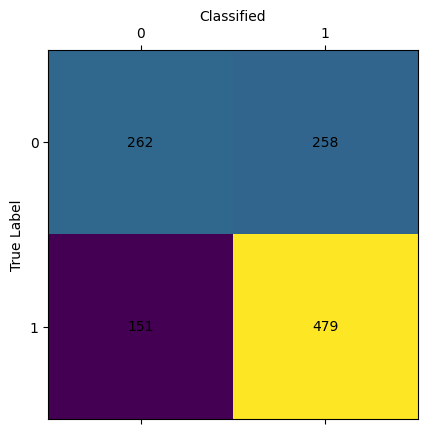

Test Set Accuracy and Balanced Accuracy
0.6443478260869565
0.6320818070818071


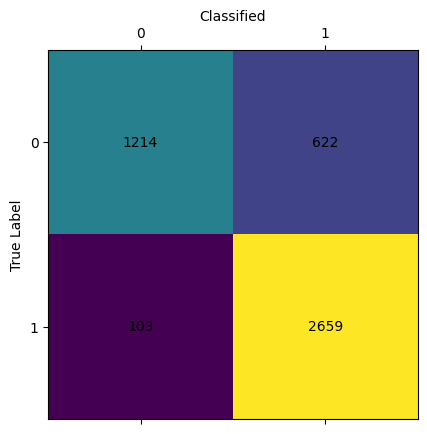

Training Set Accuracy and Balanced Accuracy
0.8423227490213137
0.8119641130247255


In [54]:

clf_rf = baselines.RandomForest(split_wholeG_torch, **opt_mod_rf)

clf_rf.fit(geom_train_mask_torch)
pred_test = clf_rf.predict(geom_test_mask_torch)
pred_train = clf_rf.predict(geom_train_mask_torch)

ev.plot_confusion_matrix(clf_rf.y[geom_test_mask_torch], pred_test, [0,1])
#print(ev.eval_roc_auc(clf_rf.y[geom_test_mask_torch], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_rf.y[geom_test_mask_torch], pred_test))
print(balanced_accuracy_score(clf_rf.y[geom_test_mask_torch], pred_test))


ev.plot_confusion_matrix(clf_rf.y[geom_train_mask_torch], pred_train, [0,1])
# extreme overfitting
print("Training Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_rf.y[geom_train_mask_torch], pred_train))
print(balanced_accuracy_score(clf_rf.y[geom_train_mask_torch], pred_train))



# Support Vector Machine

### Grid search for the optimal support vector machine model

In [55]:
param_grid_svc = {'C': [1, 100, 10000], 'kernel': ["linear", "rbf"]}
grid_list_svc = list(ParameterGrid(param_grid_svc))

opt_mod_svm, max_acc_svm, opt_bal_acc_svm =  gridSearch(baselines.SVM, split_wholeG_torch, grid_list_svc)

# {'C': 10000, 'kernel': 'linear'}
#0.5598039215686275
#0.44860112286408277

print(opt_mod_svm)
print(max_acc_svm)
print(opt_bal_acc_svm)

{'C': 10000, 'kernel': 'rbf'}
0.6365217391304347
0.626449938949939


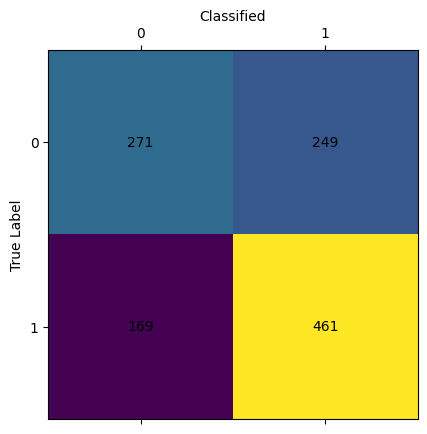

Test Set Accuracy and Balanced Accuracy
0.6365217391304347
0.626449938949939


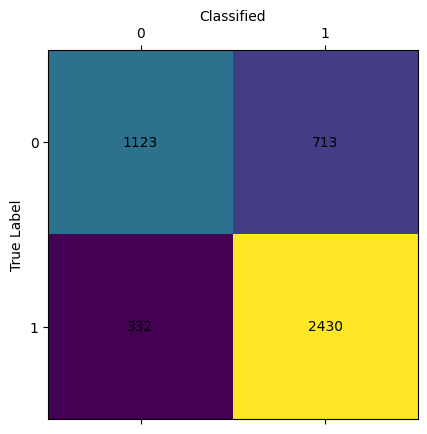

Training Set Accuracy and Balanced Accuracy
0.7727272727272727
0.7457265108956126


In [59]:
clf_svm = baselines.SVM(split_wholeG_torch,**opt_mod_svm)

clf_svm.fit(geom_train_mask_torch)
pred_test = clf_svm.predict(geom_test_mask_torch)
pred_train = clf_svm.predict(geom_train_mask_torch)

ev.plot_confusion_matrix(clf_svm.y[geom_test_mask_torch], pred_test, [0,1])
#print(ev.eval_roc_auc(clf_svm.y[geom_test_mask_torch], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_svm.y[geom_test_mask_torch], pred_test))
print(balanced_accuracy_score(clf_svm.y[geom_test_mask_torch], pred_test))

ev.plot_confusion_matrix(clf_svm.y[geom_train_mask_torch], pred_train, [0,1])
# extreme overfitting
print("Training Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_svm.y[geom_train_mask_torch], pred_train))
print(balanced_accuracy_score(clf_svm.y[geom_train_mask_torch], pred_train))



# MLP

### Grid search for the optimal MLP model

/home/laurin/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


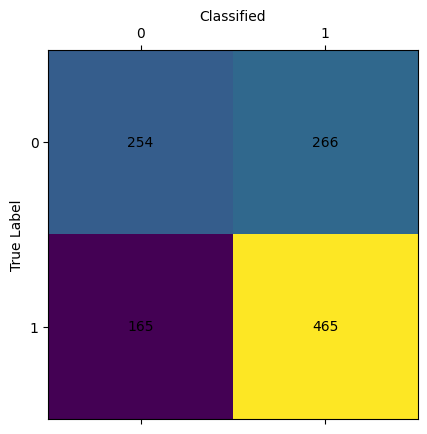

Test Set Accuracy and Balanced Accuracy
0.6252173913043478
0.6132783882783883


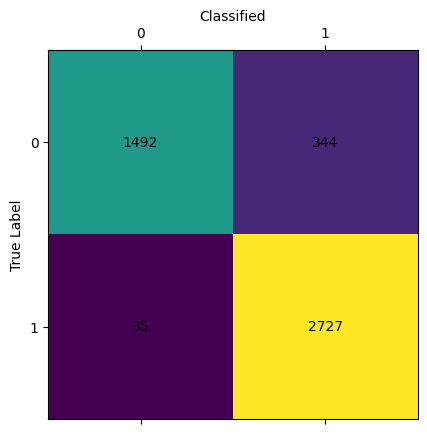

Training Set Accuracy and Balanced Accuracy
0.9175728577642454
0.8999820943744784


In [57]:
clf_mlp = baselines.MLP(split_wholeG_torch, max_iter = 3000, hidden_layer_sizes=(64,32,16),random_state=1234567, learning_rate = "adaptive", learning_rate_init = 0.01, tol =  -1)

clf_mlp.fit(geom_train_mask_torch)
pred_test = clf_mlp.predict(geom_test_mask_torch)
pred_train = clf_mlp.predict(geom_train_mask_torch)

ev.plot_confusion_matrix(clf_mlp.y[geom_test_mask_torch], pred_test, [0,1])
#print(ev.eval_roc_auc(clf_mlp.y[geom_test_mask_torch], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_mlp.y[geom_test_mask_torch], pred_test))
print(balanced_accuracy_score(clf_mlp.y[geom_test_mask_torch], pred_test))

ev.plot_confusion_matrix(clf_mlp.y[geom_train_mask_torch], pred_train, [0,1])
# extreme overfitting
print("Training Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_mlp.y[geom_train_mask_torch], pred_train))
print(balanced_accuracy_score(clf_mlp.y[geom_train_mask_torch], pred_train))



18
[0 1]


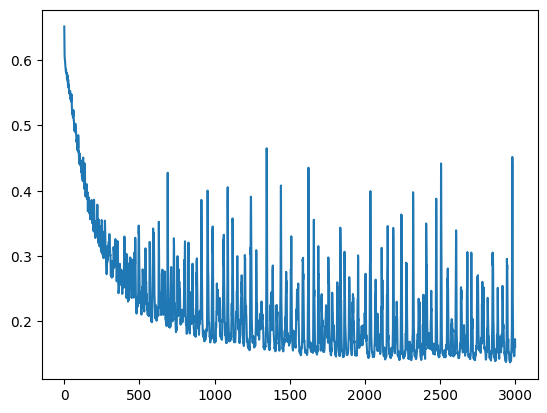

In [58]:
plt.plot(clf_mlp.clf.loss_curve_)
print(clf_mlp.clf.n_features_in_)
print(clf_mlp.clf.classes_)